In [1]:
#1. Import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers,losses,callbacks,applications,models
import numpy as np
import matplotlib.pyplot as plt
import os,datetime
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
#2. Data loading

PATH = "C:\\Users\\Wan Roslini\\Desktop\\project\\Capstone-Project 3-Image-Classification"

train_dir = os.path.join(PATH, 'Concrete-Crack-Images')

BATCH_SIZE = 10
IMG_SIZE = (160, 160)

dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 40000 files belonging to 2 classes.


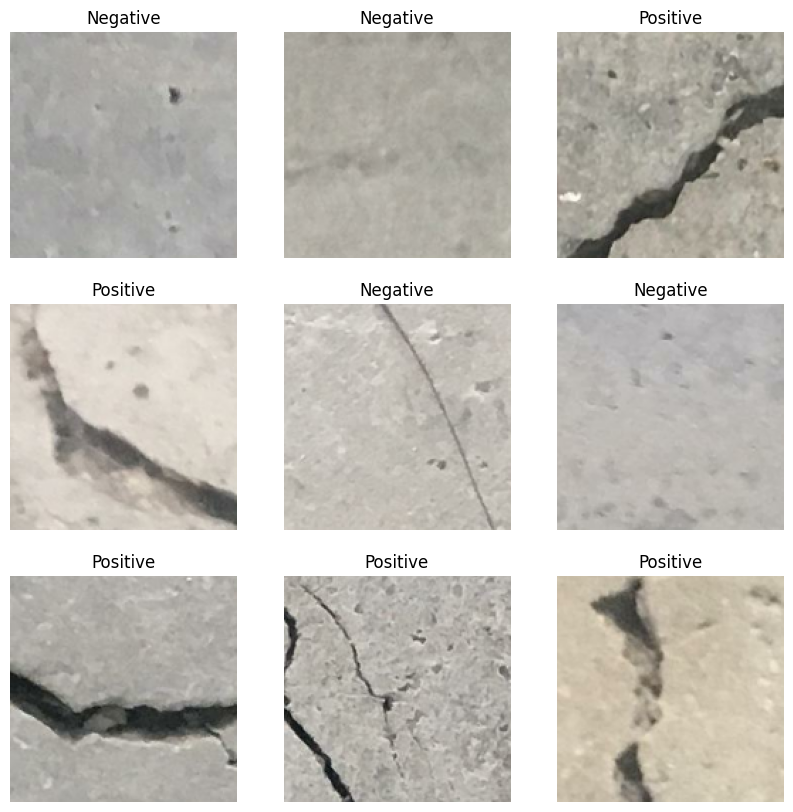

In [3]:
#3. Inspect some data examples
class_names = dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
# split dataset
train_size = int(len(dataset)*.7)
val_size = int(len(dataset)*.2) # for tuning parameters like number of hidden layers
test_size = int(len(dataset)*.1) # solely for getting the performance of the model

In [5]:
train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size+val_size).take(test_size)

In [6]:
# Converting the tensorflow datasets into PrefetchDataset
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
# Define a layer for data normalization/rescaling
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

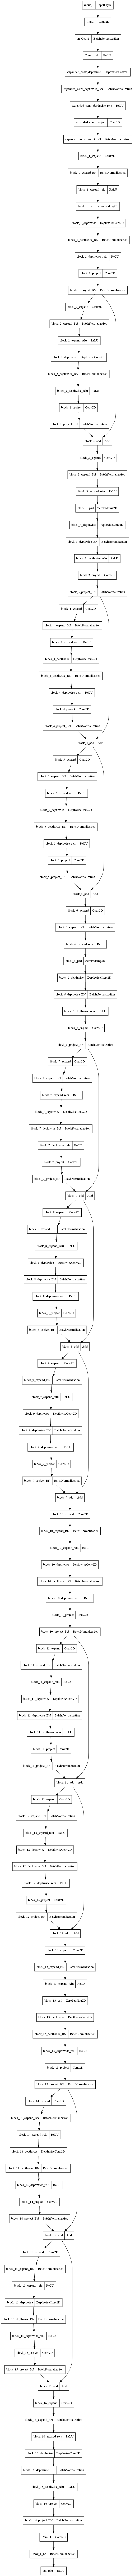

In [8]:
# Start to apply transfer learning

IMG_SHAPE = IMG_SIZE + (3,)
#Load the pretrained model
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
#Display summary of the model
base_model.summary()
#Display the structure of the model
keras.utils.plot_model(base_model)


In [9]:
# Freeze the entire feature extractor
base_model.trainable = False

#Show model summary to prove that the model parameters are frozen i.e. non-trainable
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [17]:
# Create a global average pooling layer to obtain our final extracted features
global_avg = layers.GlobalAveragePooling2D()

# Create the output layer
output_layer = layers.Dense(1, activation='sigmoid')

In [18]:
# Build the entire model using functional API
inputs = keras.Input(shape=IMG_SHAPE)
x = preprocessing.Rescaling(1./127.5, offset= -1)(inputs)  # Rescale pixel values to the range [-1, 1]
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_avg(x)
x = layers.Dropout(0.3)(x)
outputs = output_layer(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [19]:
# Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = 'binary_crossentropy'  # Use binary cross-entropy for binary classification

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [20]:
logdir = 'logs_tl'
tb = keras.callbacks.TensorBoard(log_dir=logdir)

In [21]:
# Evaluate before model training
loss0, acc0 = model.evaluate(test_dataset)

print("---------------------Evaluation before training-------------------")
print("Loss =", loss0)
print("Accuracy =", acc0)

4000/4000 [==============================] - 1027s 256ms/step - loss: 0.6863 - accuracy: 0.4725
---------------------Evaluation before training-------------------
Loss = 0.6863337159156799
Accuracy = 0.4725250005722046


In [22]:
# Proceed with model training
erls = callbacks.EarlyStopping(patience=3)
EPOCHS = 3

history = model.fit(train_dataset,validation_data=validation_dataset,epochs=EPOCHS,callbacks=[tb,erls])

Epoch 1/3
4000/4000 [==============================] - 2006s 500ms/step - loss: 0.5514 - accuracy: 0.7379 - val_loss: 0.4092 - val_accuracy: 0.9146
Epoch 2/3
4000/4000 [==============================] - 1707s 427ms/step - loss: 0.3789 - accuracy: 0.8769 - val_loss: 0.3088 - val_accuracy: 0.9252
Epoch 3/3
4000/4000 [==============================] - 1703s 426ms/step - loss: 0.3105 - accuracy: 0.8985 - val_loss: 0.2591 - val_accuracy: 0.9333


In [24]:
# Evaluate the model after training
loss1, acc1 = model.evaluate(test_dataset)

print("Loss = ", loss1)
print("Accuracy = ", acc1)

4000/4000 [==============================] - 878s 219ms/step - loss: 0.2591 - accuracy: 0.9333
Loss =  0.25907576084136963
Accuracy =  0.9333000183105469


In [25]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

predictions = model.predict_on_batch(image_batch)

In [29]:
# Create a label map for the classes
label_map = {i:names for i,names in enumerate(class_names)}

prediction_index = np.argmax(predictions,axis=1)

prediction_label = [label_map[i] for i in prediction_index]

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(prediction_label[i])
    plt.axis("off")

plt.show()

In [31]:
# saving model
model.save(os.path.join('models', 'model_tl.h5'))

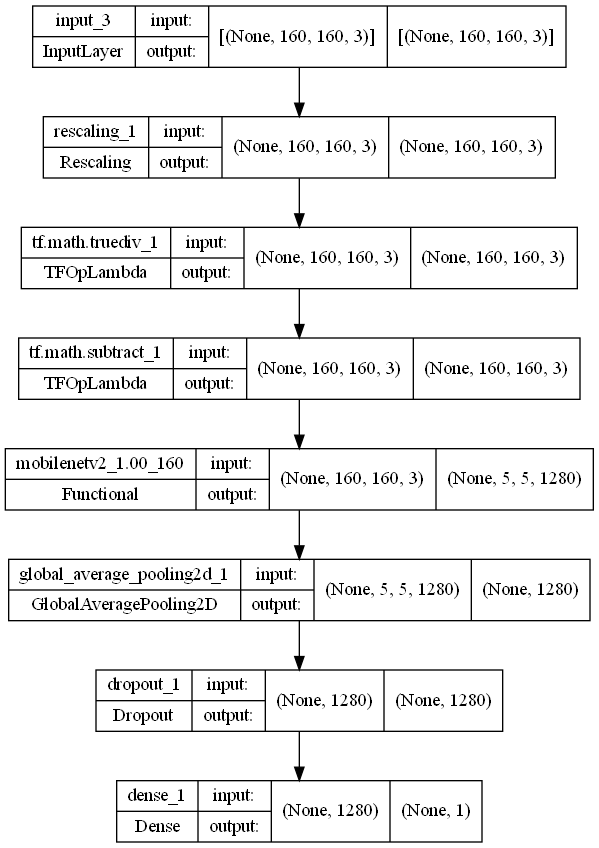

In [33]:
# plot model architecture and save as png
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_arch_tl.png', show_shapes=True)